### 1. 분석 대상
- 네이버 부동산에서 크롤링한 원룸/투룸의 전/월세 가격 정보
- 신촌, 합정, 당산 일대의 부동산 정보
### 2. 분석 목표
- '남향'이라는 기준이 가격에 미치는 영향을 분석

### 3. EDA 및 전처리

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

%matplotlib inline
warnings.filterwarnings(action='ignore')

In [2]:
df = pd.read_csv('room_price_spec.csv')
df

,price,spec1,spec2
0,"2억 7,300","35/29m², 2/5층, 북동향",HUG 안심대출 90프로 한도가능 준신축 투룸 전세
1,1억/10,"23/16m², 중/3층, 남동향","마포구청,가좌 역세권 준신축급 대출가능 전세 깔끔한 원룸"
2,"1억 5,000","37/23m², 7/8층, 남동향",성산동 넓은 원룸 중기청80
3,"3억 5,000","39/39m², 3/5층, 남동향","신축급2룸, 보증보험, 대출가능, 마포구청역 도보7분, 빠른 입주가능"
4,"3억 3,000","30/25m², 6/6층, 남서향",NaN
...,...,...,...
3104,"2억 5,000","26/21m², 5/5층, 남향",1.5룸 보증보험 신축급 풀옵션 학생 세브란스근무자 강추
3105,1억/50,"30A/16m², 저/12층, 북동향",빠른입주 가능한 깔끔한 오피스텔
3106,"2억 6,000","25/22m², 2/5층, 남서향",풀옵션원룸 전세자금대출가능
3107,"4억 3,000","33/29m², 3/5층, 남서향",빠른입주가능한 풀옵션원룸 전세자금대출가능


#### 전처리 : 데이터 정제
1. 파생변수
    - 전/월세 정보 구분
        - 전세가 1, 월세가 0
    - 보증금 column
    - 월세 column
    - 면적 column
    - 층 column
    - 남향 column
        - 남향이어야만 1
        - 남향이 아니면 0
2. feature drop
    - spec2: 비정형 데이터 column drop
3. 결측치 제거
    - dropna()

In [3]:
# 이상치 제거: 보증금 2억 5천, 월세가 43억 7500
pf = df['price'].apply(lambda x : x.split('/')[1] if '/' in x else 0)
df[pf == "43억 7,500"]

,price,spec1,spec2
1501,"2억 5,000/43억 7,500","43/29m², 고/14층, 남향","영등포구청역 초역세권,보증금조절가능.보증보험가능"


In [4]:
df = df[pf != "43억 7,500"]
pf = df['price'].apply(lambda x : x.split('/')[1] if '/' in x else 0)
df[pf == "43억 7,500"]

,price,spec1,spec2


In [5]:
# 파생변수 만들기

# 보증금 계산 함수 정의
def deposit(x):
    # 전/월세 가격 형식 통일
    x = x.split('/')[0]

    # 자리수 계산해서 더하기
    # 1억 이상인 경우: '억' 글자가 있는 경우에만 split
    if len(x.split('억')) >= 2:
        hunnit_million = int(x.split('억')[0]) * 10000
    else:
        hunnit_million = 0

    try:
        ten_million = int(x.split('억')[-1].split(',')[0]) * 1000
        million = int(x.split('억')[-1].split(',')[1])
    # error case: 억단위로 맞아떨어져서 이하 숫자가 없는 경우
    except:
        ten_million = 0
        million = 0
    return hunnit_million + ten_million + million

df['전/월세'] = df['price'].apply(lambda x : 0 if '/' in x else 1)
df['보증금'] = df['price'].apply(lambda x : deposit(x))
df['월세'] = df['price'].apply(lambda x : int(x.split('/')[1]) if '/' in x else 0)

# 공통적으로 사용할 전처리 함수 정의
def parser(x, num):
    return x.split(', ')[num]
def sup_area(x):
    sup = parser(x, 0).split('/')[0]
    try:
        sup = int(sup)
    except:
        try:
            sup = int(sup[:-2])
        except:
            try:
                sup = int(sup[:-3])
            except:
                sup = int(sup[:-4])
    return sup
def use_area(x):
    use = parser(x, 0).split('/')[1].replace('m²', "")
    try:
        use = int(use)
    except:
        use = int(use[:-2])
    return use

df['공급면적'] = df['spec1'].apply(lambda x: sup_area(x))
df['전용면적'] = df['spec1'].apply(lambda x: use_area(x))
df['층'] = df['spec1'].apply(lambda x: int(parser(x, 1).split('/')[1].replace('층', '')))
df['남향'] = df['spec1'].apply(lambda x: 1 if '남향' in parser(x, 2) else 0)

In [6]:
# 이상치 제거 2: 전용면적은 공급면적보다 클 수 없음
drop_index = df[df['전용면적'] > df['공급면적']].index
df = df.drop(drop_index, axis=0)
df[df['전용면적'] > df['공급면적']]

# feature drop
df = df.drop(['price', 'spec1', 'spec2'], axis=1)

# 결측치 제거
df = df.dropna()

df

,전/월세,보증금,월세,공급면적,전용면적,층,남향
0,1,27300,0,35,29,5,0
1,0,10000,10,23,16,3,0
2,1,15000,0,37,23,8,0
3,1,35000,0,39,39,5,0
4,1,33000,0,30,25,6,0
...,...,...,...,...,...,...,...
3103,1,12500,0,55,45,3,0
3104,1,25000,0,26,21,5,1
3106,1,26000,0,25,22,5,0
3107,1,43000,0,33,29,5,0


### 4. 시각화
1. 전세와 월세 각각의 경우
    - 면적과 금액을 축으로 하여 scatter plot을 그렸다.
    - 전세와 월세의 경우 모두, 남향 특성 군집의 뚜렷한 차이는 확인되지 않는다.

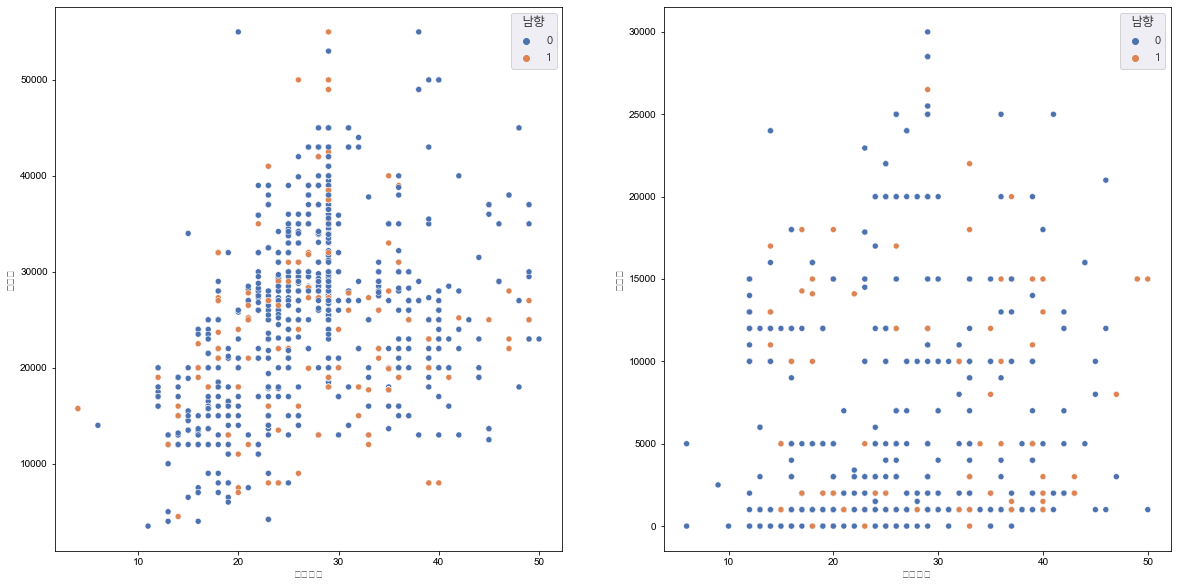

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))
sns.set(font='Malgun Gothic')
sns.scatterplot(data=df[df['전/월세']==1], x='전용면적', y='보증금', hue='남향', ax=ax[0])
sns.scatterplot(data=df[df['전/월세']==0], x='전용면적', y='보증금', hue='남향', ax=ax[1])
plt.show()

<AxesSubplot:xlabel='공급면적', ylabel='월세'>

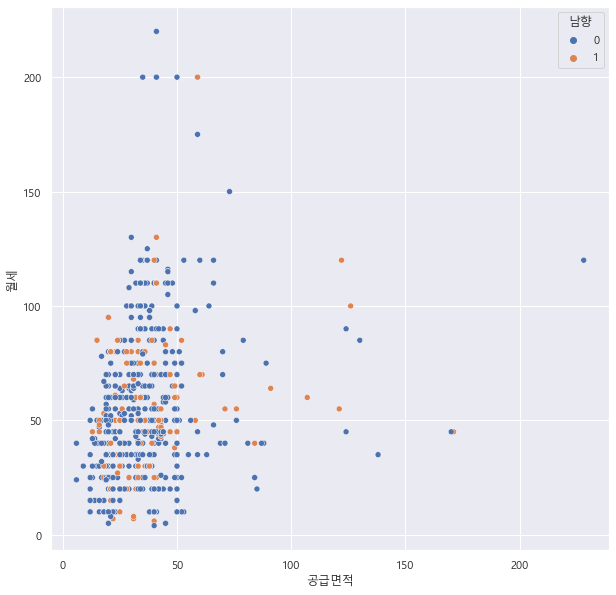

In [8]:
plt.figure(figsize=(10, 10))
sns.scatterplot(data=df[df['전/월세']==0], x='공급면적', y='월세', hue='남향')

2. 층에 따른 가격에 대해 boxplot을 그렸다.
    - 전용면적 20 이하의 작은 방에서는 6~8층 대에서 남향 가구의 보증금이 더 비쌌다.
    - 전용면적 20 이상의 큰 방에서는 13~14층 대에서 남향 가구의 보증금이 더 비쌌다.

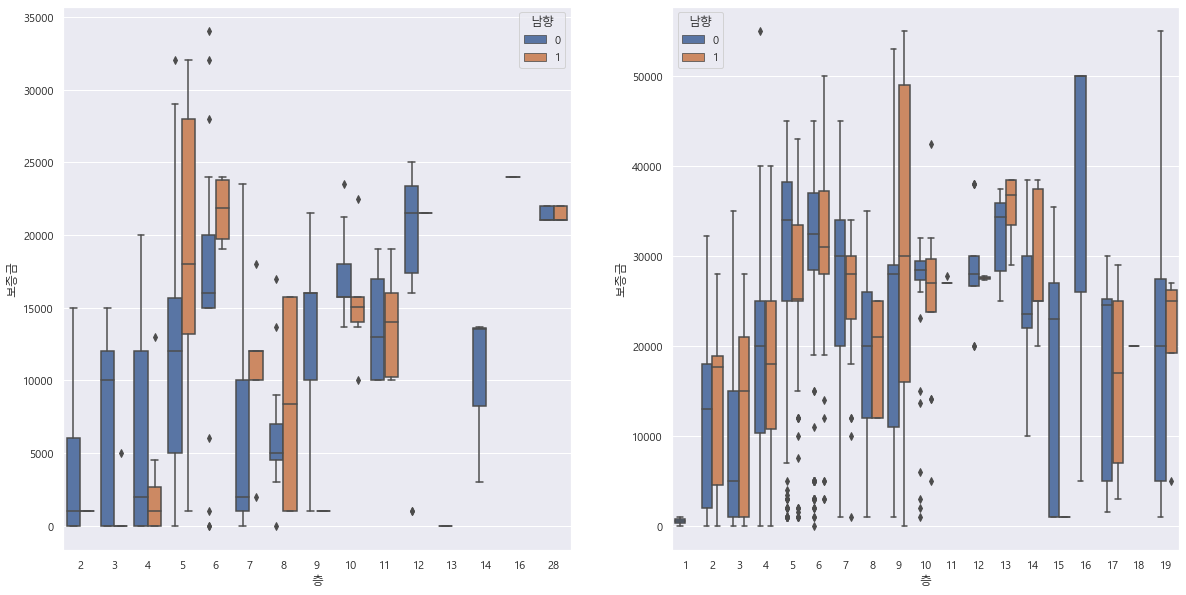

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))
sns.boxplot(data=df[df['전용면적'] < 20], x='층', y='보증금', hue='남향', ax=ax[0])
sns.boxplot(data=df[df['전용면적'] >= 20], x='층', y='보증금', hue='남향', ax=ax[1])
plt.show()


In [10]:
df.to_csv('preped.csv', index=False)